# 0. Set Up

In [1]:
# Import general modules/packages here. 
# It is a good practice to run all cells in the Notebook sequentially to avoid unexpected outputs.

import numpy as np


# force Jupyter to update loaded modules as they change 
%load_ext autoreload
%autoreload 2

# Before you continue ...
Please download and add the folder from the exercise page to the root directory of this project.      
www.rostlab.org/~bindpredict/datasets_pp1cb/disorder.zip


The folder name should be **data**. The folder contains following files: 


-- baseline_embeddings_disorder.h5     
-- disorder_seq.fasta    
-- README.md      
-- disorder_labels.fasta     
-- MSAs      
 
 
**TO DO**: add a method for automatical download.


Run the next cell to display the structure of the repo: 

In [4]:
!ls

data  methods  README.md  visualization  workflow.ipynb


**methods** 


-- utils    
-- nn
 Contains the actual code for pre-processing and definition of our NN. 


**visualization**     
Contains methods for ploting and the output folder with images. 



This notebook is meant to be a main driver which imports all methods and performs machine learning pipeline in abstract high-level calls. It means: we will implement the actual dataset import, network definition and training here by importing an appropriate function into the notebook. 

# Table of contents 
TO DO 

# 1. Dataset preparation

## Visualize the dataset

Reading Z-scores...done! Found 1102 proteins.
Plotting histogram of all z-scores...done! 125223 usable z-scores in total. 5.05% of all z-scores were unknown and hence removed from the histogram.
Plotting histogram of the protein lengths...done! Median length: 114.0.


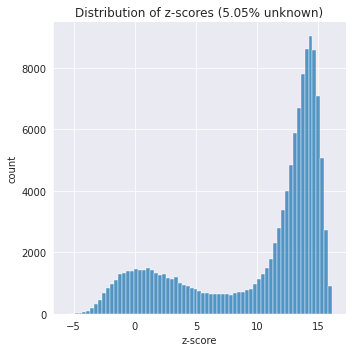

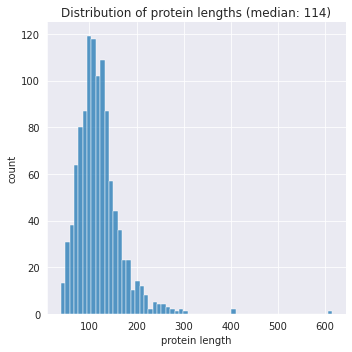

In [5]:
import visualization.visualize_dataset as vis
from methods.utils.read_embeddings import read_z_scores

z_scores = read_z_scores(z_score_file="./data/disorder_labels.fasta")
vis.plot_z_score_histogram(z_scores)
vis.plot_protein_length_histogram(z_scores)

## Embeddings
Here is an example how an embedding works. 
Each aa seq is represented as a numpy array of size (num_of_aa, 1024), where each number is a z-score. 

In [2]:
import methods.nn.disorder_dataset as dd

dataset = dd.load_dataset()

Reading embeddings...done! Found 1102 proteins.
Reading Z-scores...done! Found 1102 proteins.
Matching protein IDs...done!
Samples per bin [ 94  66 256 686]
Thresholds of bins [-1.89092126  2.24897056  6.38886238 10.5287542  14.66864602]


In [7]:
test_index = np.random.randint(10)
test_x = dataset.x[test_index]
test_y = dataset.y[test_index]
seq_length, embedding_dim = test_x.shape
print(test_x.shape)
print(test_y.shape)
test_y.sum()/len(test_y)

(133, 1024)
(133,)


98.06987218045113

## Load the dataset

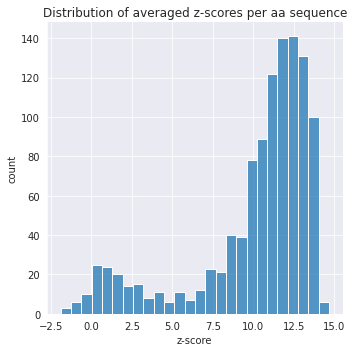

In [8]:
from visualization.visualize_dataset import plot_avg_z_score_histogramm

plot_avg_z_score_histogramm(dataset.avg_y)

## Split the dataset to k-folds

### Sample train/test/val datasets k-times
Sampling from each of the bins ensures stratification or, in other words, that the distribution of the data is equal in every set. 


In [16]:
import torch 

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from methods.nn.disorder_dataset import collate
from methods.nn.disorder_dataset import DisorderDataset


def nested_cross_validation(dataset,
                            model=None,
                            mode='print_fold_info',
                            k=10, *kwargs):
    
    # Set fixed random number seed
    SEED = 1
    torch.manual_seed(SEED) 
    
    # Define the K-fold Cross Validator
    skf = StratifiedKFold(n_splits=k, random_state=SEED, shuffle=True)

    # For folds results
    results = {}
    # For debugging loaders 
    loaders = {}

    # Nested K-Fold Cross Validation model evaluation
    # We split the data stratified on artificially constructed bins in df['bins'
    # and extract indices.
    
    # By splitting we only extract indices of samples for each test/train/val sets,
    # thus we only need either X or y (equal length).
    # For stratification, however, we require the artificially assigned bins whic are also defined in the 
    # dataset class
    
    data = dataset.y
    stratify_on = dataset.bins
    
    for fold, (train_val_ids, test_ids) in enumerate(skf.split(data,stratify_on)):
        
        print(f"Fold {fold}")
        
        train_ids, val_ids = train_test_split(train_val_ids, 
                                  test_size=0.20,  # 0.25 x 0.8 = 0.2
                                  stratify=stratify_on[train_val_ids], 
                                  random_state=SEED)
    

        # Define data loaders for training and testing data in this fold
        valloader = torch.utils.data.DataLoader(
                          dataset, 
                          batch_size=10,
                          collate_fn=collate,
                          sampler=val_ids)

        trainloader = torch.utils.data.DataLoader(
                          dataset,
                          collate_fn=collate,
                          batch_size=10, sampler=train_ids)

        testloader = torch.utils.data.DataLoader(
                          dataset,
                          collate_fn=collate,
                          batch_size=10, sampler=test_ids)
        
        if mode == 'print_fold_info':
            
            loaders[fold] = [trainloader, valloader, testloader]
            
            print('train -  {}, avg_len - {:.2f}  |  val -  {}, avg_len - {:.2f}'.format(
                np.sum(np.bincount(stratify_on[train_ids])),
                np.sum(dataset.aa_len[train_ids])/len(train_ids),
                np.sum(np.bincount(stratify_on[val_ids])),
                np.sum(dataset.aa_len[val_ids])/len(val_ids)))

            print('test -  {}, avg_len - {:.2f}'.format(
                np.sum(np.bincount(stratify_on[test_ids])),
                np.sum(dataset.aa_len[test_ids])/len(test_ids)))
            
            show_batches = 5
            for i,batch in enumerate(trainloader):
                print('Embedding: \n', batch['embeddings'])
                print('\nZ-scores: \n', batch['z_scores'])
                print('\nSequence Lengths: \n', batch['lengths'])
                print('\n')
                if i == show_batches:
                    break
                  
            print()
            
        elif mode == 'evaluate':
            pass
        else:
            print("Mode is not specified!")
            break
        
    if mode == 'evaluate':
        return results
    else:
        return loaders

In [17]:
nested_cross_validation(dataset)

Fold 0
train -  792, avg_len - 120.46  |  val -  199, avg_len - 115.51
test -  111, avg_len - 121.62
Embedding: 
 tensor([[[ 0.0066, -0.0684, -0.0231,  ...,  0.4983,  0.1930,  0.1927],
         [-0.1213, -0.3159, -0.0352,  ...,  0.0051,  0.0526, -0.0237],
         [-0.2056, -0.3350, -0.0152,  ...,  0.3633, -0.1221,  0.3767],
         ...,
         [-0.0279, -0.2654, -0.0224,  ...,  0.3042, -0.0332,  0.1641],
         [-0.2969, -0.3613, -0.1354,  ...,  0.0840, -0.1511,  0.0407],
         [ 0.1102, -0.0884,  0.0955,  ...,  0.3608,  0.1335,  0.2827]],

        [[ 0.0038,  0.1085, -0.1855,  ...,  0.4539,  0.0350, -0.2590],
         [-0.0034, -0.0626, -0.1687,  ...,  0.2325, -0.0124,  0.2395],
         [ 0.0818, -0.0182, -0.2605,  ...,  0.3235,  0.3547, -0.1954],
         ...,
         [-0.0505, -0.1967, -0.0221,  ...,  0.2922,  0.1877, -0.1595],
         [-0.3894, -0.1913, -0.2034,  ...,  0.2883, -0.1105,  0.0318],
         [ 0.4062,  0.1528, -0.2854,  ...,  0.7168,  0.1050, -0.4917]],

  

 tensor([[[ 0.0134, -0.2839, -0.1490,  ...,  0.1407,  0.0659,  0.2600],
         [-0.1632, -0.0961,  0.0811,  ...,  0.1854, -0.1421,  0.1693],
         [-0.0411, -0.2211, -0.3440,  ...,  0.2795,  0.2386,  0.0970],
         ...,
         [ 0.0813, -0.1676, -0.0914,  ...,  0.2856,  0.1013, -0.0992],
         [-0.5371, -0.0153, -0.1897,  ..., -0.0483, -0.3982,  0.0582],
         [-0.4597, -0.4258,  0.0904,  ...,  0.0835, -0.3020,  0.2815]],

        [[ 0.0070, -0.0582, -0.1625,  ...,  0.3899,  0.1461, -0.0835],
         [ 0.2642,  0.0123, -0.0683,  ...,  0.4382,  0.2588, -0.2289],
         [-0.1095, -0.1406, -0.3374,  ...,  0.3379,  0.1797, -0.0465],
         ...,
         [ 0.0988, -0.0315, -0.0329,  ...,  0.2930,  0.1846,  0.1049],
         [-0.5908,  0.1727, -0.2295,  ...,  0.0382, -0.2274, -0.2291],
         [-0.4148, -0.2625,  0.0406,  ...,  0.1862, -0.1439,  0.1436]],

        [[-0.0333, -0.1043,  0.0867,  ...,  0.3643,  0.1954,  0.1742],
         [ 0.1261, -0.0972,  0.0892,  ...,  

Embedding: 
 tensor([[[-0.0644, -0.2825, -0.0719,  ...,  0.1788,  0.0793,  0.0101],
         [-0.0793, -0.3230,  0.1981,  ...,  0.0707, -0.2563,  0.2671],
         [ 0.0107, -0.3872,  0.0701,  ..., -0.0467,  0.1094,  0.2063],
         ...,
         [-0.0986, -0.0967,  0.0899,  ...,  0.3442,  0.3267, -0.1713],
         [-0.3071, -0.2629,  0.2218,  ...,  0.1140, -0.2065,  0.3118],
         [ 0.1027, -0.2607,  0.0248,  ..., -0.1898,  0.1004,  0.0749]],

        [[ 0.4321,  0.0665, -0.2477,  ...,  0.3684,  0.2651, -0.3315],
         [-0.1125, -0.0650, -0.3091,  ...,  0.3975, -0.0456, -0.3516],
         [ 0.0319, -0.2649,  0.0320,  ...,  0.1326,  0.2961, -0.1418],
         ...,
         [-0.1898, -0.1968, -0.0725,  ...,  0.1995,  0.0467, -0.1621],
         [-0.1926, -0.3213,  0.0616,  ...,  0.2561,  0.1246, -0.2037],
         [ 0.1849, -0.0040, -0.1213,  ..., -0.0230, -0.1465, -0.0178]],

        [[-0.1504, -0.2939, -0.0260,  ..., -0.0384,  0.0205,  0.1710],
         [ 0.1174, -0.1981,  0.0

{0: [<torch.utils.data.dataloader.DataLoader at 0x7f4fd5151da0>,
 1: [<torch.utils.data.dataloader.DataLoader at 0x7f4fd51513c8>,
 2: [<torch.utils.data.dataloader.DataLoader at 0x7f4fd51514a8>,
 3: [<torch.utils.data.dataloader.DataLoader at 0x7f5000a5e6d8>,
 4: [<torch.utils.data.dataloader.DataLoader at 0x7f5000a5e5c0>,
 5: [<torch.utils.data.dataloader.DataLoader at 0x7f4fd5151e10>,
 6: [<torch.utils.data.dataloader.DataLoader at 0x7f4fd515d160>,
 7: [<torch.utils.data.dataloader.DataLoader at 0x7f4fd515d390>,
 8: [<torch.utils.data.dataloader.DataLoader at 0x7f4fd515d588>,
 9: [<torch.utils.data.dataloader.DataLoader at 0x7f4fd515d4a8>,
  <torch.utils.data.dataloader.DataLoader at 0x7f4fd515d358>]}

# 2. Create a model
TO DO

# 3. Train a model
TO DO

# 4. Visualize results